# 주가 예측 (ARIMA)

### 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller

# Time Series 생성
# 삼성전자 2020.09.07~2021.09.07 데이터
data_path = os.getenv('HOME') + '/aiffel/stock_prediction/005930.KS.csv'
df = pd.read_csv(data_path, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    56500.0
2020-09-08    58700.0
2020-09-09    58400.0
2020-09-10    59200.0
2020-09-11    59000.0
Name: Close, dtype: float64

### 전처리

In [2]:
len(ts)

249

In [3]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [4]:
# 결측치 처리
# ts.interpolate(method='time')

In [5]:
# 로그변환
ts_log = np.log(ts)

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    plt.subplot(211)
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')

    plt.subplot(212)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Standard Deviation')
    
    plt.tight_layout()
    plt.show(block=False)


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

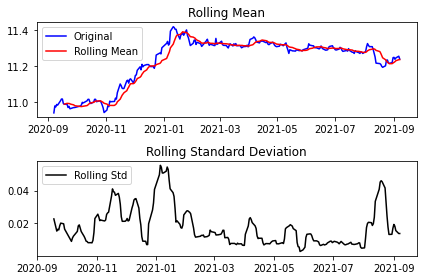

Results of Dickey-Fuller Test:
Test Statistic                  -2.317941
p-value                          0.166247
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

- 안정성을 조절해줘야 함(p값 0.16 으로 ts_log는 안정성있다고 판단하기 어려움)

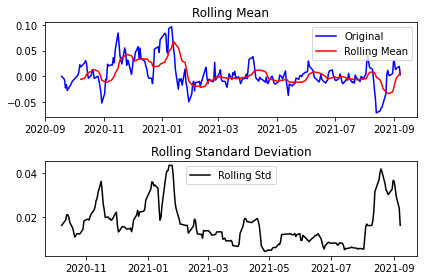

Results of Dickey-Fuller Test:
Test Statistic                  -4.554397
p-value                          0.000157
#Lags Used                       1.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


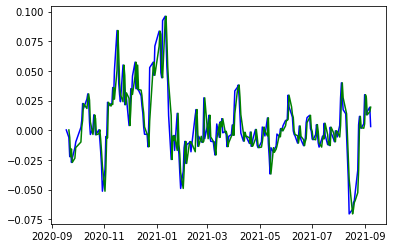

In [8]:
# moving average 제거 - trend 상쇄
moving_avg = ts_log.rolling(window=10).mean()
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.dropna(inplace=True)

plot_rolling_statistics(ts_log_moving_avg)
augmented_dickey_fuller_test(ts_log_moving_avg)

# 차분 - 계절성 파악
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

- 이동평균 제거 후 pvalue 0.000157 로 낮아짐

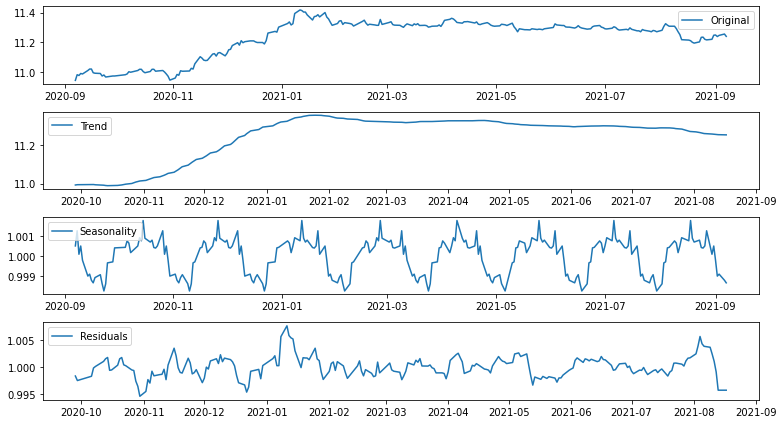

In [9]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
# pvalue 값 확인 (정량 분석)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.971511e+00
p-value                        1.931278e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


- pvalue 낮음. 안정적이라고 할 수 있음.

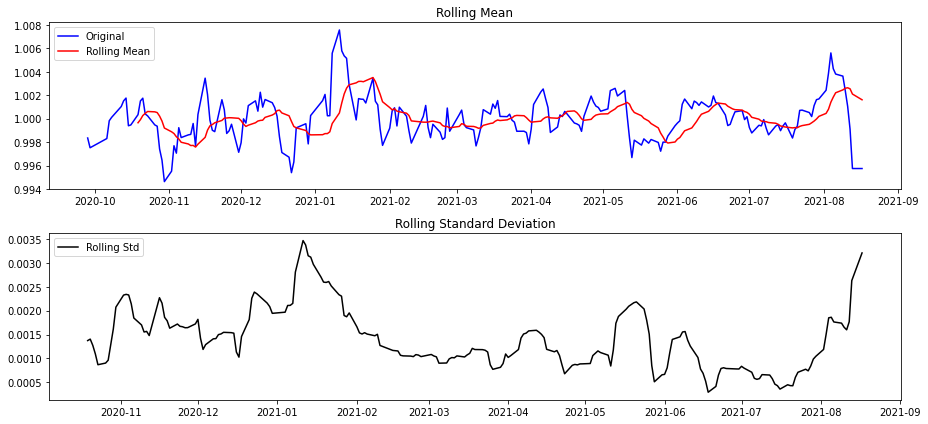

In [11]:
# 시각화(정성분석)
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

### ARIMA 모델로 시계열 예측

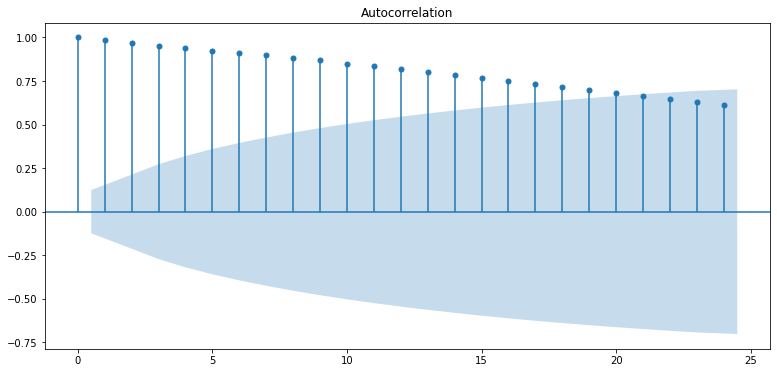

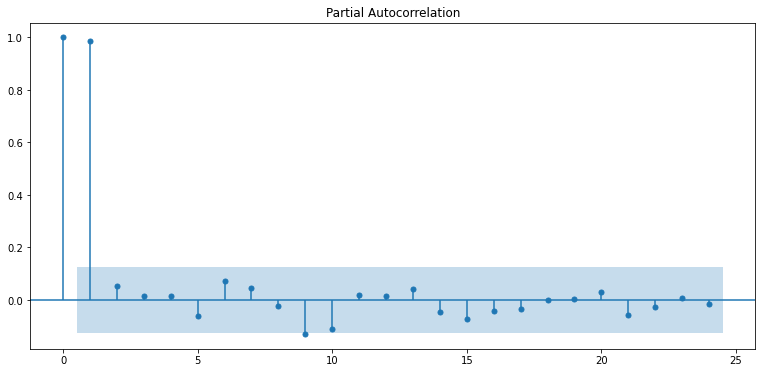

Results of Dickey-Fuller Test:
Test Statistic                -1.144065e+01
p-value                        6.190607e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.169859e+00
p-value                        2.822955e-10
#Lags Used                     1.300000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


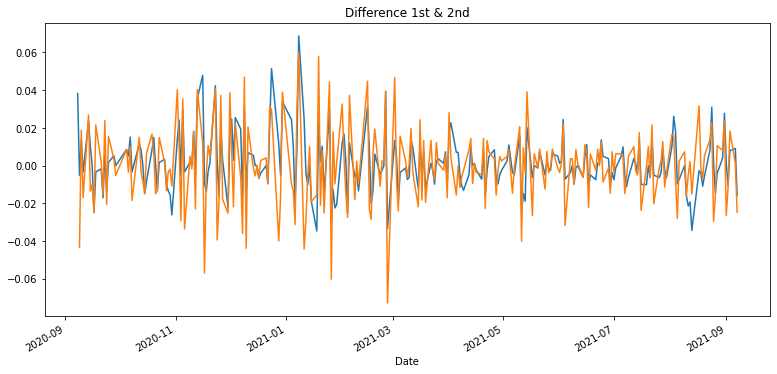

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot()

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 1st & 2nd')

augmented_dickey_fuller_test(diff_2)

**ARIMA 모델 모수 p,q,d 설정**
- ACF 그래프는 점차 감소, PACF 그래프는 p=1 이후 값이 0 이므로 AR(1) 모델이 적합할 것 같다.
- p = 1, q = 0
- 1차 차분 pvalue값이 낮기 때문에 안정성 있다고 볼 수 있음. d = 1 부터 테스트

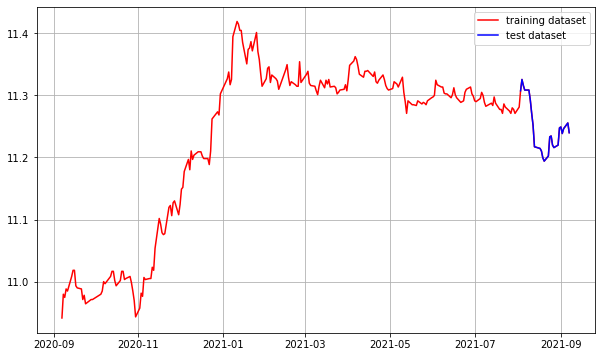

In [13]:
# 훈련, 테스트 데이터셋 분리
train_data, test_data = ts_log[:-25], ts_log[-25:]

# 시각화
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 622.762
Method:                       css-mle   S.D. of innovations              0.015
Date:                Wed, 08 Sep 2021   AIC                          -1239.523
Time:                        02:02:28   BIC                          -1229.302
Sample:                             1   HQIC                         -1235.397
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.001      1.493      0.136      -0.000       0.004
ar.L1.D.Close     0.0293      0.068      0.432      0.666      -0.104       0.162
                                    Root

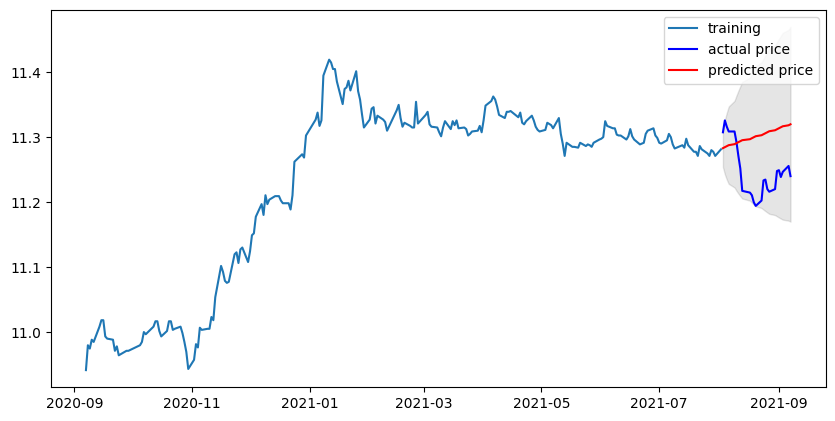

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
# p = 1, d = 1, q = 0
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())


# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  29691989.836581055
MAE:  4965.136705014953
RMSE:  5449.035679510738
MAPE: 6.57%


## 삼성전자 주가 미래에 대한 예측 해보기

- 9.7 이후 30일 예측

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  248
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 691.326
Method:                       css-mle   S.D. of innovations              0.015
Date:                Wed, 08 Sep 2021   AIC                          -1376.652
Time:                        02:02:28   BIC                          -1366.112
Sample:                             1   HQIC                         -1372.409
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.181      0.237      -0.001       0.003
ar.L1.D.Close     0.0747      0.064      1.165      0.244      -0.051       0.200
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


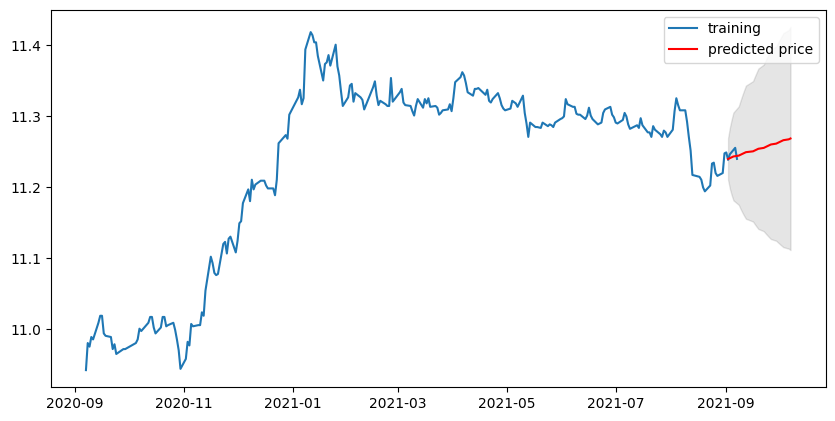

In [16]:
from datetime import timedelta

# Build Model
model = ARIMA(ts_log, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(25, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index + timedelta(days=30))   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index+ timedelta(days=30))  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index+ timedelta(days=30))  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(ts_log, label='training')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

## 다양한 주식 종가 예측해보기

In [32]:
def load_and_decompose(data_path):
    # 데이터 불러오기
    df = pd.read_csv(data_path, index_col='Date', parse_dates=True)
    ts = df['Close']
    ts_log = np.log(ts)
    
    #시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성
    
    # 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)
    
    return ts_log
    
    
def parameter_setting(ts_log):
    # ARIMA 모델 모수 설정
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot()

    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 1st & 2nd')

    augmented_dickey_fuller_test(diff_2)


def model_arima(ts_log, p=1, d=1, q=0):    
    # 훈련, 테스트 데이터셋으로 분리
    train_data, test_data = ts_log[:-25], ts_log[-25:]
    
    # Build Model
    print('-----------------------------------------')
    print('*******ARIMA 모델로 시계열 데이터 학습********\n')
    model = ARIMA(train_data, order=(p, d, q))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드
    
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('>>>>>>>>>>>>>>> 훈련 결과')
    print('>>>>>>>>>>>>>>> MAPE: {:.2f}%'.format(mape*100))
    
    # Build Model
    print('\n>>>>>>>>>>>>>>>>>30일 이후 예측')
    model = ARIMA(ts_log, order=(p, d, q))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(25, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index + timedelta(days=30))   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index+ timedelta(days=30))  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index+ timedelta(days=30))  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(ts_log, label='training')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

In [33]:
kakao = os.getenv('HOME') + '/aiffel/stock_prediction/kakao.csv'
aapl = os.getenv('HOME') + '/aiffel/stock_prediction/AAPL.csv'
lg = os.getenv('HOME') + '/aiffel/stock_prediction/lgelectronics.csv'

Results of Dickey-Fuller Test:
Test Statistic                  -5.136302
p-value                          0.000012
#Lags Used                       1.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


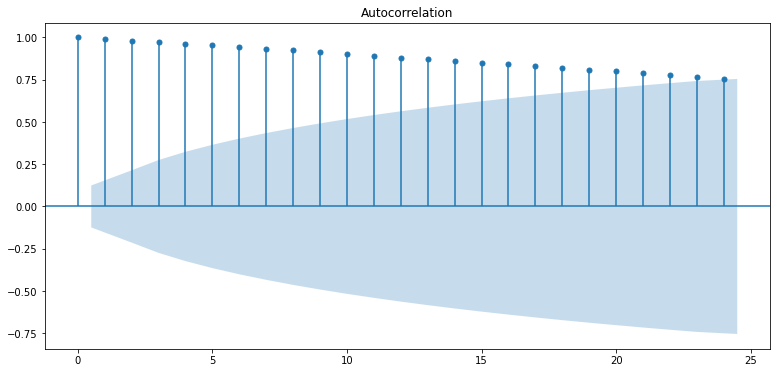

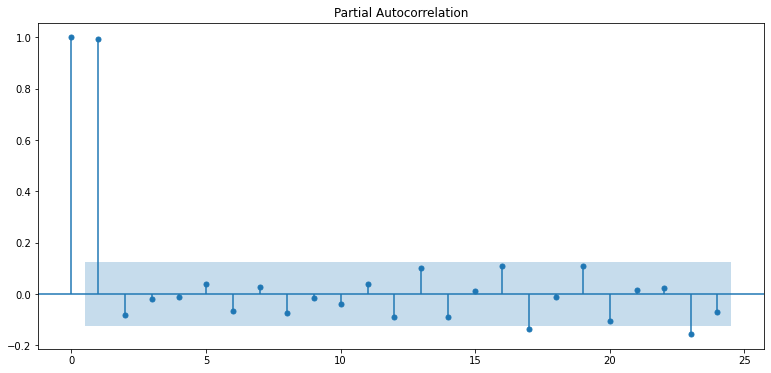

Results of Dickey-Fuller Test:
Test Statistic                -1.473688e+01
p-value                        2.607150e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.286018e+00
p-value                        4.388726e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


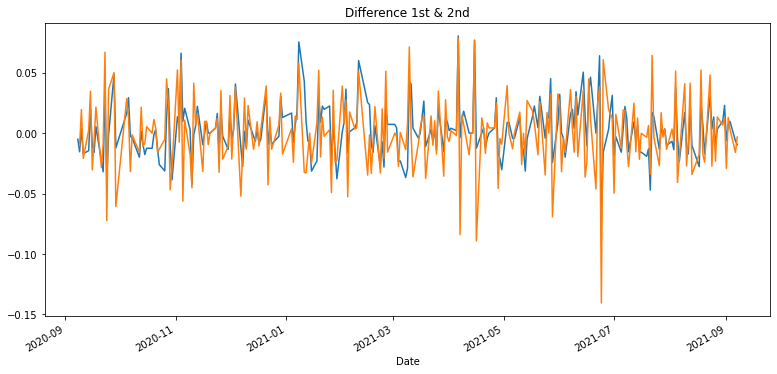

In [34]:
kakao = load_and_decompose(kakao)
parameter_setting(kakao)

- acf, pacf 그래프 모양을 보면 AR(1) 모델에 적합하다는 것을 알 수 있고, 1차 혹은 2차 차분 모두 안정성을 보인다.
- 즉, 모수를 p = 1, d = 1, q = 0 혹은  p = 1, d = 2, q = 0 로 설정할 수 있다.

-----------------------------------------
*******ARIMA 모델로 시계열 데이터 학습********

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 532.828
Method:                       css-mle   S.D. of innovations              0.022
Date:                Wed, 08 Sep 2021   AIC                          -1059.656
Time:                        02:11:17   BIC                          -1049.435
Sample:                             1   HQIC                         -1055.530
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0028      0.002      1.713      0.087      -0.000       0.006
ar.L1.D.Close     0.0851      0.067      1.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

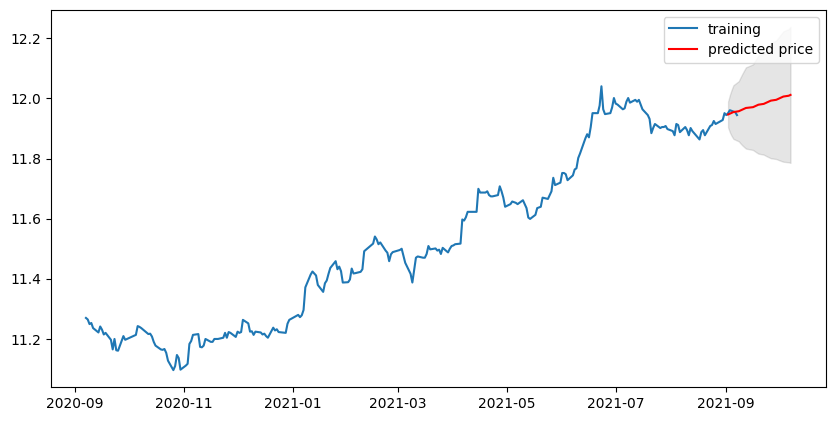

-----------------------------------------
*******ARIMA 모델로 시계열 데이터 학습********

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  222
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 486.109
Method:                       css-mle   S.D. of innovations              0.027
Date:                Wed, 08 Sep 2021   AIC                           -966.219
Time:                        02:11:17   BIC                           -956.011
Sample:                             2   HQIC                          -962.097
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.007e-06      0.001      0.002      0.999      -0.002       0.002
ar.L1.D2.Close    -0.4394      0.060    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

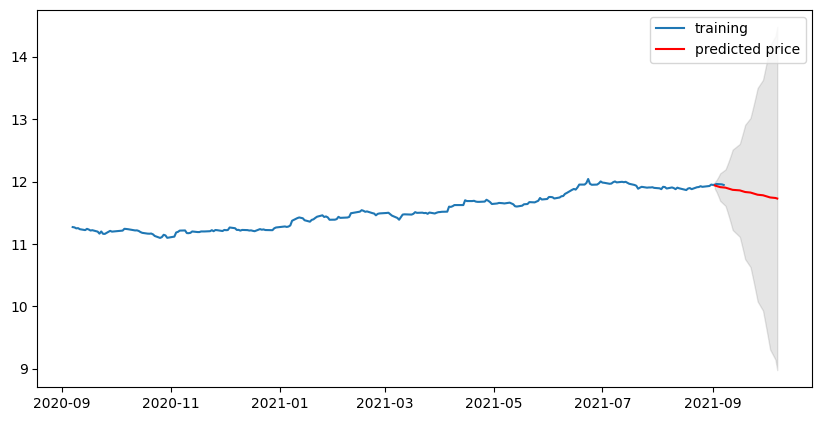

In [35]:
model_arima(kakao, p = 1, d = 1, q = 0)
model_arima(kakao, p = 1, d = 2, q = 0)

p = 1, d = 1, q = 0 일때는 MAPE 1.84% 로 오차가 낮아지는데, d=2로 설정하면 MAPE 11.31% 로 증가한다.

Results of Dickey-Fuller Test:
Test Statistic                -9.521101e+00
p-value                        3.063306e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.206000e+03
Critical Value (1%)           -3.435784e+00
Critical Value (5%)           -2.863940e+00
Critical Value (10%)          -2.568048e+00
dtype: float64


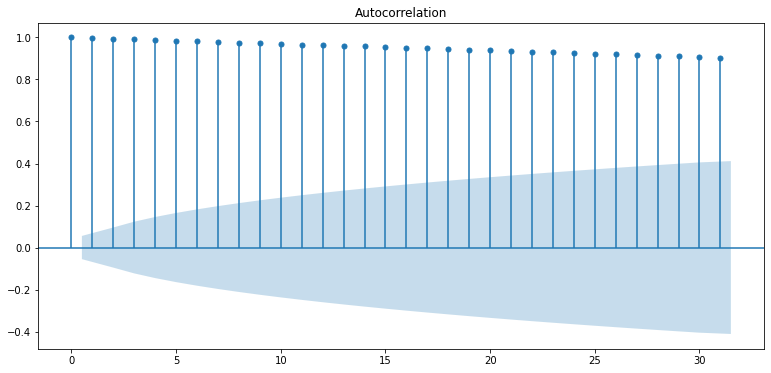

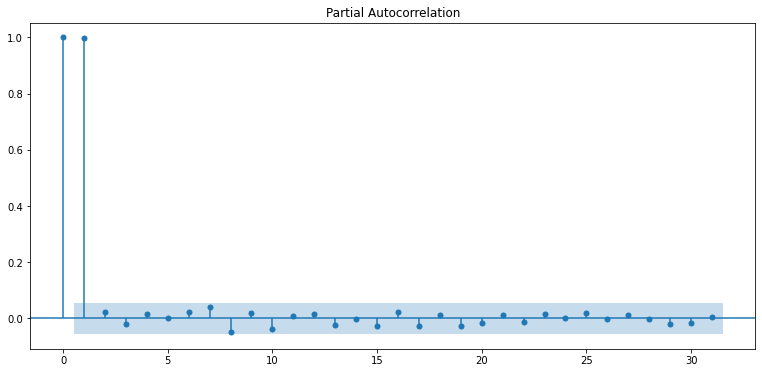

Results of Dickey-Fuller Test:
Test Statistic                -1.099899e+01
p-value                        6.756949e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.556487e+01
p-value                        2.020804e-28
#Lags Used                     1.700000e+01
Number of Observations Used    1.238000e+03
Critical Value (1%)           -3.435643e+00
Critical Value (5%)           -2.863877e+00
Critical Value (10%)          -2.568014e+00
dtype: float64
-----------------------------------------
*******ARIMA 모델로 시계열 데이터 학습********

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1232
Model:                 ARIMA(1, 1, 0)   Log Likelihood 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1257
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3204.000
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 08 Sep 2021   AIC                          -6401.999
Time:                        02:11:19   BIC                          -6386.590
Sample:                             1   HQIC                         -6396.208
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.000      2.931      0.003       0.000       0.002
ar.L1.D.Close    -0.1280      0.028     -4.575      0.000      -0.183      -0.073
                                    Root

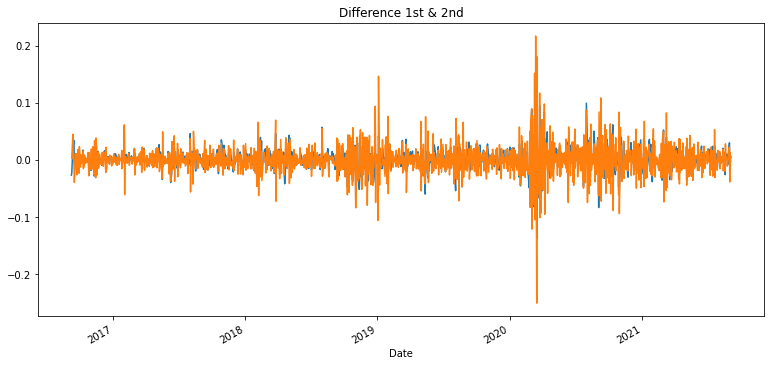

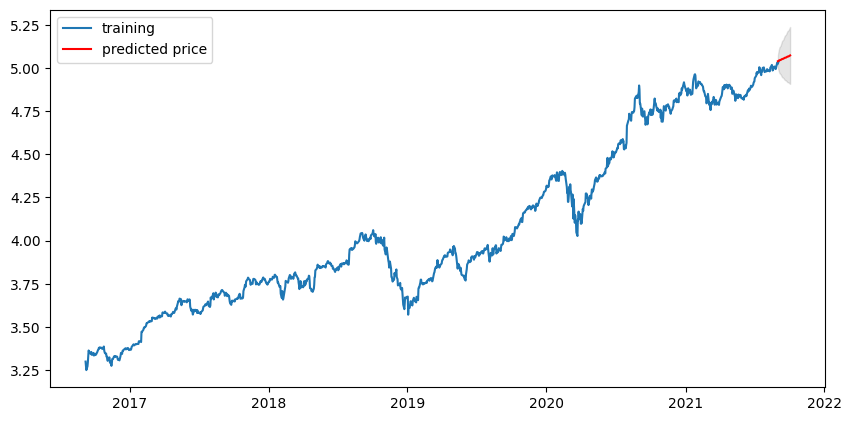

In [36]:
aapl = load_and_decompose(aapl)
parameter_setting(aapl)
model_arima(aapl)

- p = 1, d = 1, q = 0 일때 MAPE 1.02% 로 낮다.

Results of Dickey-Fuller Test:
Test Statistic                  -5.492708
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


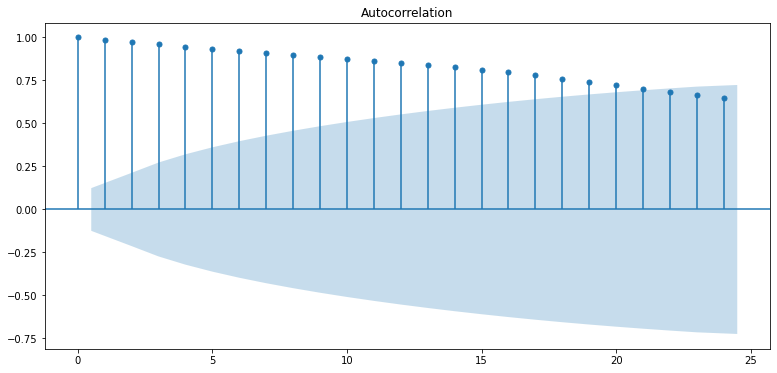

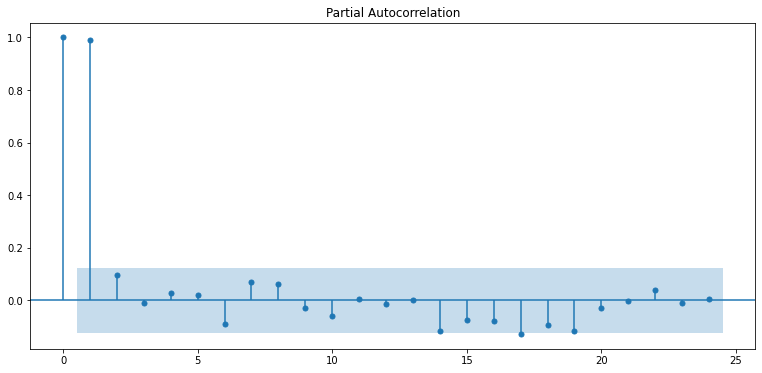

Results of Dickey-Fuller Test:
Test Statistic                -1.744859e+01
p-value                        4.666373e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.999308e+00
p-value                        2.357367e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64
-----------------------------------------
*******ARIMA 모델로 시계열 데이터 학습********

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

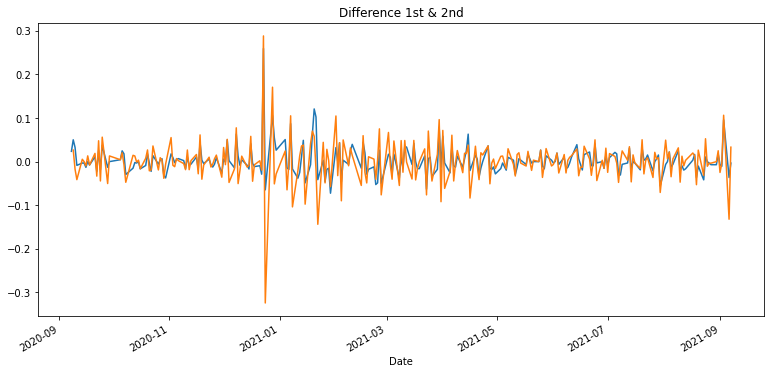

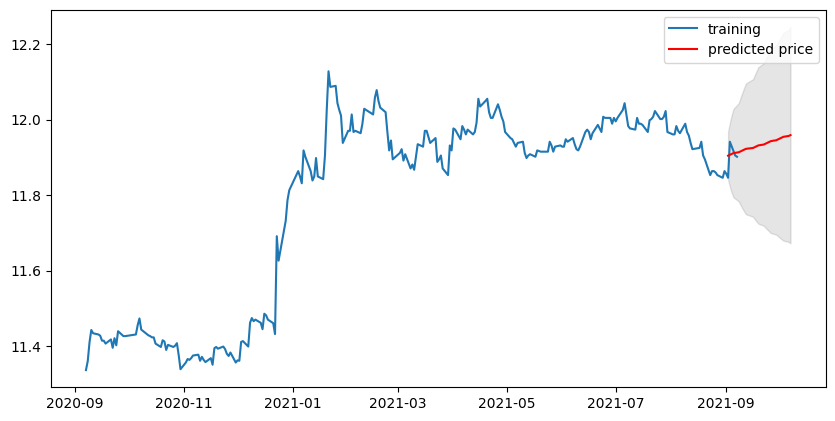

In [38]:
lg = load_and_decompose(lg)
parameter_setting(lg)
model_arima(lg)

MAPE: 9.56% 로 앞의 모델보다 오차가 높다.

-----------------------------------------
*******ARIMA 모델로 시계열 데이터 학습********



/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  222
Model:                ARIMA(0, 2, 12)   Log Likelihood                 446.185
Method:                       css-mle   S.D. of innovations              0.032
Date:                Wed, 08 Sep 2021   AIC                           -864.369
Time:                        02:18:58   BIC                           -816.732
Sample:                             2   HQIC                          -845.136
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.477e-05      0.000     -0.291      0.771      -0.001       0.000
ma.L1.D2.Close     -1.0671      0.067    -15.889      0.000      -1.199      -0.936
ma.L2.D2.Close      0.2114      

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  247
Model:                ARIMA(0, 2, 12)   Log Likelihood                 500.252
Method:                       css-mle   S.D. of innovations              0.032
Date:                Wed, 08 Sep 2021   AIC                           -972.504
Time:                        02:19:21   BIC                           -923.372
Sample:                             2   HQIC                          -952.723
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.403e-05      0.000     -0.186      0.852      -0.001       0.000
ma.L1.D2.Close     -1.0742      0.064    -16.883      0.000      -1.199      -0.949
ma.L2.D2.Close      0.2132      

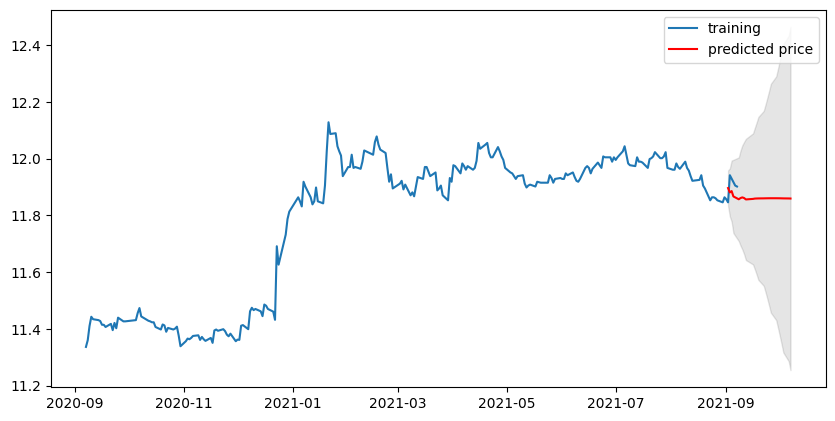

In [40]:
model_arima(lg, p = 0, d = 2, q = 12)

모수를 p = 0, d = 2, q = 12로 설정하면, MAPE: 2.51%로 낮출 수 있습니다. -> MA(12)

### 회고

- 실제 주가를 arima 모델로 예측해보면서 시계열 데이터에 대한 이해를 기를 수 있었다.
- 하지만 주가에는 과거의 종가보다 영향을 미치는 요소가 많기 때문에 더 주의깊게 모델링을 해야할 필요가 있다. 특히 주가는 회사의 이슈나 경제상황, 이자율 등이 영향을 미치기 때문에 단순히 과거 종가를 arima 모델로 예측하는 것 이상의 모델링이 필요할 것 같다. pandas Series 데이터 타입은 가격 데이터만 가지고 있지만, 다른 영향 요인들(feature)을 추가하여 예측을 하기 위해 LSTM 등 RNN 계열 딥러닝을 활용할 수도 있을 것 같다.
- [링크](https://github.com/minji2744/PlanetA/blob/main/task4_forecasting_pm2_5.ipynb) 는 제가 최근에 24시간 후 미세먼지의 양을 예측하는데 LSTM 모델을 사용한 예시입니다.(이처럼 LSTM을 활용할 때에는 예측할 변수 + 영향 미치는 변수들을 추가하여 적용할 수 있다)

![model](model.png)

![model](train.png)

![model](result.png)